In [93]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import galpy
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import astropy.units as u
from astropy.coordinates import SkyCoord
#from matplotlib.backends.backend_pdf import PdfPages
import imageio
import os
import glob
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial import ConvexHull


plt.rcParams["font.family"] = "Times New Roman"
hdul = fits.open('asu_topcat.fits') # open a FITS file of the 256 stars
data = hdul[1].data  # assume the first extension is a table
t = Table(data)
#initialize 
ra_list = t.columns['RA_ICRS']
dec_list = t.columns['DE_ICRS']
pmra_list = t.columns['pmRA']
parallax = (t.columns['Plx'])/1000 #units of plx are milliarcseconds (mas) &&& 1 arc second = 1000 mas 
pmdec_list = t.columns['pmDE']
rv_list = t.columns['RV']
gcR_list = t.columns['gcR']
gcPHI_list = t.columns['gcPHI']
gcZ_list = t.columns['gcZ']
gcPHI_list = -(gcPHI_list -np.pi)
gcvR_list = t.columns['gcvR']
gcvPHI_list = t.columns['gcvPHI']
gcvZ_list = t.columns['gcvZ']

In [156]:
def OrbitIntegrate3D(time, pathname, increment = 5): 
    
    orbits= Orbit(vxvv=[gcR_list*u.pc,gcvR_list*u.km/u.s,gcvPHI_list*u.km/u.s,gcZ_list*u.pc,gcvZ_list*u.km/u.s,
                        gcPHI_list*u.rad])
    ts= np.linspace(0,time,10000)*u.Myr
    orbits.integrate(ts,MWPotential2014)
    sun = Orbit()
    sun.integrate(ts,MWPotential2014)
    
    tlist = []
    density = []
    xrangelist = []
    yrangelist = []
    zrangelist = []
    if time < 0:
        plotrange = np.arange(time, 0, increment)*u.Myr
        angle_noPOV = 45
    else:
        plotrange = np.arange(0, time+increment, increment)*u.Myr
        angle_noPOV = 135
    
     
    for i in plotrange:  
        fig = plt.figure(figsize = (8,8))
        ax1 = fig.gca(projection='3d')

        if time < 0:
            ax1.set_title('t='+ str(i+120*u.Myr)  +'     ('  + str(i)+' ago)'  , fontsize= 16)
        else:
            ax1.set_title('t='+ str(i+120*u.Myr)  +'     ('  + str(i)+' future)'  , fontsize= 16)

        #rotating axes to get the rest frame of the stream
        theta = np.median(orbits.phi(i))
        x_p = orbits.x(i)*np.cos(theta) + orbits.y(i)*np.sin(theta)
        y_p = -orbits.x(i)*np.sin(theta) + orbits.y(i)*np.cos(theta)
        z_p = orbits.z(i)        
        vx_p = orbits.vx(i)*np.cos(theta) + orbits.vy(i)*np.sin(theta)
        vy_p = -orbits.vx(i)*np.sin(theta) + orbits.vy(i)*np.cos(theta)
        vz_p = orbits.vz(i)
        
        x_p_sun = sun.x(i)*np.cos(theta) + sun.y(i)*np.sin(theta)
        y_p_sun = -sun.x(i)*np.sin(theta) + sun.y(i)*np.cos(theta) 
        z_p_sun = sun.z(i)
        #print(x_p-np.median(x_p))
        x_psubmed = x_p-np.median(x_p)
        y_psubmed = y_p-np.median(y_p)
        z_psubmed = z_p-np.median(z_p)

        den = ConvexHullDensity(x_psubmed, y_psubmed, z_psubmed)
        print('t='+ str(i+120*u.Myr), 'i:', i, '   density:', den)
        density.append(den)
        tlist.append((i+120*u.Myr))
        
        xrangelist.append(max(x_psubmed)-min(x_psubmed))
        yrangelist.append(max(y_psubmed)-min(y_psubmed))
        zrangelist.append(max(z_psubmed)-min(z_psubmed))
        
                


        ax1.quiver(x_psubmed, y_psubmed, z_psubmed, vx_p-np.median(vx_p), vy_p-np.median(vy_p), vz_p-np.median(vz_p), length = .009, arrow_length_ratio = 0.25, colors = 'k')
        ax1.scatter(x_psubmed, y_psubmed, z_psubmed, s=50, color = 'c', edgecolors = 'k')
        #ax1.scatter(x_p-np.median(x_p), y_p-np.median(y_p), zs = 0, zdir = 'z', s=50, color = 'c', edgecolors = 'k')
        #ax1.scatter(x_p-np.median(x_p), z_p-np.median(z_p), zs = 0, zdir = 'y', s=50, color = 'c', edgecolors = 'k')
        #ax1.scatter(y_p-np.median(y_p), z_p-np.median(z_p), zs = 0, zdir = 'x', s=50, color = 'c', edgecolors = 'k')

        #ax1.quiver(sun.x(i), sun.y(i), (sun.vx(i)-np.median(orbits.vx(i))), (sun.vy(i)-np.median(orbits.vy(i))), width = 1/400)

        ax1.scatter(x_p_sun-np.median(x_p), y_p_sun-np.median(y_p), z_p_sun-np.median(z_p), color = 'orange', s = 50, edgecolors = 'k')
        
        pts =np.array(list(zip(x_psubmed, y_psubmed, z_psubmed)))
        hull = ConvexHull(pts)
        for s in hull.simplices:
            print(s)
            print(s[0])
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            print(pts[s,0])
            ax1.plot(pts[s, 0], pts[s, 1], pts[s, 2], ls = "-", color = "red")
        
        
        ax1.set_xlabel('X* (kpc)')
        ax1.set_ylabel('Y* (kpc)')
        ax1.set_zlabel('Z (kpc)')
        ax1.set_xlim3d(-1.75, +1.75)
        ax1.set_ylim3d(-1.75, +1.75)
        ax1.set_zlim3d(-0.3, +0.3)
        #x1, y1, _ = proj3d.proj_transform(-.5,-2.3,-.25, ax1.get_proj())
        #ax1.annotate("Increasing Galactic Radius", xy=(x1, y1), xytext=(0, 0), arrowprops=dict(arrowstyle="->"), va = 'center_baseline')
        #ax.text(9, 0, 0, "red", color='red')
    
        #print(i)
        ax1.view_init(30, angle_noPOV)
        
        #print('angle1', angle_noPOV)
        
        # the times to rotate the POV
        if i == -185.0*u.Myr:
            for angle in range(45, 138, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
                #print("angle2", angle)
            angle_noPOV = 135
                
        elif i == 60.0*u.Myr:
            for angle in range(135, 228, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
                #print("angle2", angle)
            angle_noPOV = 225
        
        elif i == 210.0*u.Myr:
            for angle in range(225, 318, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
                #print("angle2", angle)
            angle_noPOV = 315 
        
        elif i == 320.0*u.Myr:
            for angle in range(315, 408, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
       #         ax1.view_init(30, angle+90)
                #print('angle4', angle)
            angle_noPOV = 405
            
        
        ####change the ranges to 90 differences OR change inital angle 

        plt.savefig(pathname+str(i)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
        plt.close(fig)
    
    return density, tlist, xrangelist, yrangelist, zrangelist
        
def ConvexHullDensity(x, y, z):
    pts = list(zip(x, y, z))
    hull = ConvexHull(pts)
    volume = hull.volume
    density = 256/volume #number of stars / volume
    
    return density
    

def gifmaker(foldername, gifname):
    filenames = sorted(glob.glob(foldername), key = os.path.getmtime)
    with imageio.get_writer(gifname, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            

In [157]:
densitylist, tlist, xrangelist, yrangelist, zrangelist = OrbitIntegrate3D(-220.,  pathname = 'gifConvexHull/plot')

t=-100.0 Myr i: -220.0 Myr    density: 30269.01353983779
[124   3 131]
124
[0.01583152 0.01137295 0.06734315 0.01583152]
[ 38   3 131]
38
[0.05043558 0.01137295 0.06734315 0.05043558]
[215 251   3]
215
[-0.09387754 -0.05218794  0.01137295 -0.09387754]
[215 196 251]
215
[-0.09387754 -0.08144745 -0.05218794 -0.09387754]
[233 124 131]
233
[-0.04674099  0.01583152  0.06734315 -0.04674099]
[233 215 198]
233
[-0.04674099 -0.09387754 -0.11015597 -0.04674099]
[233 124   3]
233
[-0.04674099  0.01583152  0.01137295 -0.04674099]
[118 131 141]
118
[0.08319558 0.06734315 0.09698723 0.08319558]
[118  38 131]
118
[0.08319558 0.05043558 0.06734315 0.08319558]
[ 62 251   3]
62
[ 0.04727337 -0.05218794  0.01137295  0.04727337]
[ 62 251 141]
62
[ 0.04727337 -0.05218794  0.09698723  0.04727337]
[ 78 233 131]
78
[ 0.05486705 -0.04674099  0.06734315  0.05486705]
[ 78 131 141]
78
[0.05486705 0.06734315 0.09698723 0.05486705]
[ 78 101 141]
78
[0.05486705 0.06240424 0.09698723 0.05486705]
[ 72 196 251]
72
[-0.

[150   6 141]
150
[0.08641564 0.00433813 0.11652853 0.08641564]
[150 118 141]
150
[0.08641564 0.09745497 0.11652853 0.08641564]
[150 118   6]
150
[0.08641564 0.09745497 0.00433813 0.08641564]
t=-85.0 Myr i: -205.0 Myr    density: 17265.28730382536
[ 86 131 221]
86
[ 0.04257037  0.0464195  -0.04084408  0.04257037]
[231 251   6]
231
[-0.06676934 -0.02401699  0.00277574 -0.06676934]
[152  82 141]
152
[0.08488417 0.02043728 0.11881141 0.08488417]
[ 50  86 221]
50
[-0.0008377   0.04257037 -0.04084408 -0.0008377 ]
[ 50 231 221]
50
[-0.0008377  -0.06676934 -0.04084408 -0.0008377 ]
[ 50 231   6]
50
[-0.0008377  -0.06676934  0.00277574 -0.0008377 ]
[148 251 141]
148
[ 0.0883956  -0.02401699  0.11881141  0.0883956 ]
[148 251   6]
148
[ 0.0883956  -0.02401699  0.00277574  0.0883956 ]
[137 152 131]
137
[0.02821023 0.08488417 0.0464195  0.02821023]
[137 152  82]
137
[0.02821023 0.08488417 0.02043728 0.02821023]
[143  86 131]
143
[0.08567583 0.04257037 0.0464195  0.08567583]
[143 152 131]
143
[0.085

[137 124  82]
137
[ 0.03270491 -0.00689042  0.03596136  0.03270491]
[137 124 131]
137
[ 0.03270491 -0.00689042  0.03668149  0.03270491]
[141 152 150]
141
[0.11723333 0.10473984 0.11800134 0.11723333]
[141 148 150]
141
[0.11723333 0.11158421 0.11800134 0.11723333]
[141 148 136]
141
[0.11723333 0.11158421 0.09933026 0.11723333]
[143 131  86]
143
[0.10321056 0.03668149 0.058453   0.10321056]
[143 152 131]
143
[0.10321056 0.10473984 0.03668149 0.10321056]
[129   2 136]
129
[ 0.03965838 -0.00659751  0.09933026  0.03965838]
[129 141 136]
129
[0.03965838 0.11723333 0.09933026 0.03965838]
[160 136 251]
160
[-0.01434595  0.09933026 -0.03336294 -0.01434595]
[160   2 251]
160
[-0.01434595 -0.00659751 -0.03336294 -0.01434595]
[160   2 136]
160
[-0.01434595 -0.00659751  0.09933026 -0.01434595]
[ 91 152 131]
91
[0.06511546 0.10473984 0.03668149 0.06511546]
[ 91 137 131]
91
[0.06511546 0.03270491 0.03668149 0.06511546]
[ 91 137  82]
91
[0.06511546 0.03270491 0.03596136 0.06511546]
[ 91 141  82]
91
[0

[ 72   6 133]
72
[-0.03701353 -0.03406738  0.1153701  -0.03701353]
[ 72 160 133]
72
[-0.03701353 -0.00915607  0.1153701  -0.03701353]
[181 209  50]
181
[-0.06578146 -0.07490138  0.04669567 -0.06578146]
[181  86 233]
181
[-0.06578146  0.08124126 -0.06091575 -0.06578146]
[181 209 187]
181
[-0.06578146 -0.07490138 -0.08688038 -0.06578146]
[ 38 124   3]
38
[ 0.01908436  0.00721805 -0.00822528  0.01908436]
[38 91  3]
38
[ 0.01908436  0.08872773 -0.00822528  0.01908436]
[ 38  91 124]
38
[0.01908436 0.08872773 0.00721805 0.01908436]
[152 150 154]
152
[0.12408694 0.13049563 0.13238045 0.12408694]
[152 150 136]
152
[0.12408694 0.13049563 0.12763343 0.12408694]
[152  91 136]
152
[0.12408694 0.08872773 0.12763343 0.12408694]
[152  91 131]
152
[0.12408694 0.08872773 0.03772653 0.12408694]
[143  86  50]
143
[0.12106201 0.08124126 0.04669567 0.12106201]
[143 116  50]
143
[0.12106201 0.09158672 0.04669567 0.12106201]
[143  86 131]
143
[0.12106201 0.08124126 0.03772653 0.12106201]
[143 152 131]
143
[0

[ 90 161  64]
90
[ 0.07229017 -0.01150018  0.01902192  0.07229017]
[152 150 154]
152
[0.13424463 0.12829031 0.14829754 0.13424463]
[152 143 154]
152
[0.13424463 0.13076113 0.14829754 0.13424463]
[116 146 145]
116
[0.09332319 0.13760777 0.09460318 0.09332319]
[116 145  72]
116
[ 0.09332319  0.09460318 -0.05078528  0.09332319]
[116 146 154]
116
[0.09332319 0.13760777 0.14829754 0.09332319]
[116 161  72]
116
[ 0.09332319 -0.01150018 -0.05078528  0.09332319]
[116  90 161]
116
[ 0.09332319  0.07229017 -0.01150018  0.09332319]
[ 91 152 150]
91
[0.1062838  0.13424463 0.12829031 0.1062838 ]
[ 91 131   3]
91
[ 0.1062838  0.0428229 -0.0174727  0.1062838]
[ 91 150   3]
91
[ 0.1062838   0.12829031 -0.0174727   0.1062838 ]
[ 93 143 131]
93
[0.09725521 0.13076113 0.0428229  0.09725521]
[ 93 152 143]
93
[0.09725521 0.13424463 0.13076113 0.09725521]
[ 93  91 131]
93
[0.09725521 0.1062838  0.0428229  0.09725521]
[ 93  91 152]
93
[0.09725521 0.1062838  0.13424463 0.09725521]
[101 143 154]
101
[0.0929340

[124 233  93]
124
[0.05891255 0.03434691 0.12207975 0.05891255]
[124  93 240]
124
[ 0.05891255  0.12207975 -0.00371039  0.05891255]
[ 86  93 104]
86
[0.12004036 0.12207975 0.15055076 0.12004036]
[ 86 233 104]
86
[0.12004036 0.03434691 0.15055076 0.12004036]
[ 86 233  93]
86
[0.12004036 0.03434691 0.12207975 0.12004036]
t=-40.0 Myr i: -160.0 Myr    density: 14145.96813027674
[  6 221 251]
6
[-0.13462111 -0.01992634 -0.19178663 -0.13462111]
[  6 231 251]
6
[-0.13462111 -0.04131504 -0.19178663 -0.13462111]
[  6 231 221]
6
[-0.13462111 -0.04131504 -0.01992634 -0.13462111]
[ 50 231 221]
50
[ 0.0902224  -0.04131504 -0.01992634  0.0902224 ]
[ 50 233 104]
50
[0.0902224  0.06037827 0.15543631 0.0902224 ]
[ 50 233 221]
50
[ 0.0902224   0.06037827 -0.01992634  0.0902224 ]
[191 221 251]
191
[-0.15829778 -0.01992634 -0.19178663 -0.15829778]
[191 204 251]
191
[-0.15829778 -0.14355996 -0.19178663 -0.15829778]
[191 204 221]
191
[-0.15829778 -0.14355996 -0.01992634 -0.15829778]
[215  72 251]
215
[-0.17

t=-25.0 Myr i: -145.0 Myr    density: 8528.481449076162
[204   3 251]
204
[-0.1343265  -0.03334646 -0.26261281 -0.1343265 ]
[ 50 233 104]
50
[0.09951035 0.15474123 0.16792555 0.09951035]
[  6 204 251]
6
[-0.18593922 -0.1343265  -0.26261281 -0.18593922]
[  2   3 251]
2
[-0.17218349 -0.03334646 -0.26261281 -0.17218349]
[160   2 251]
160
[-0.14198453 -0.17218349 -0.26261281 -0.14198453]
[160   2   3]
160
[-0.14198453 -0.17218349 -0.03334646 -0.14198453]
[ 82 124   3]
82
[ 0.10183229  0.1281814  -0.03334646  0.10183229]
[ 82 160   3]
82
[ 0.10183229 -0.14198453 -0.03334646  0.10183229]
[ 85  50 231]
85
[ 0.12233046  0.09951035 -0.05233542  0.12233046]
[ 85  50 104]
85
[0.12233046 0.09951035 0.16792555 0.12233046]
[187   6 204]
187
[-0.04708375 -0.18593922 -0.1343265  -0.04708375]
[187 167 204]
187
[-0.04708375  0.04883747 -0.1343265  -0.04708375]
[221  50 231]
221
[ 0.0534955   0.09951035 -0.05233542  0.0534955 ]
[221   6 231]
221
[ 0.0534955  -0.18593922 -0.05233542  0.0534955 ]
[221 187 

[104  64  50]
104
[0.15779691 0.13706749 0.09257438 0.15779691]
[181 209   6]
181
[ 0.12865819 -0.0791173  -0.21324376  0.12865819]
[181 187   6]
181
[ 0.12865819 -0.01202933 -0.21324376  0.12865819]
[181   5  50]
181
[0.12865819 0.13279458 0.09257438 0.12865819]
[181 209  50]
181
[ 0.12865819 -0.0791173   0.09257438  0.12865819]
[181 187 221]
181
[ 0.12865819 -0.01202933  0.10298016  0.12865819]
[181   5 233]
181
[0.12865819 0.13279458 0.20585928 0.12865819]
[181 221 233]
181
[0.12865819 0.10298016 0.20585928 0.12865819]
t=-10.0 Myr i: -130.0 Myr    density: 11268.3061457743
[  3 160 251]
3
[-0.03597418 -0.2125639  -0.31675427 -0.03597418]
[ 72 160 251]
72
[-0.19627433 -0.2125639  -0.31675427 -0.19627433]
[  6  72 251]
6
[-0.22427424 -0.19627433 -0.31675427 -0.22427424]
[  6 204 251]
6
[-0.22427424 -0.11416154 -0.31675427 -0.22427424]
[135   3 160]
135
[ 0.00432263 -0.03597418 -0.2125639   0.00432263]
[ 64 181 233]
64
[0.14297205 0.14929101 0.224747   0.14297205]
[ 64 181  50]
64
[0.1

[221 181 187]
221
[0.16453246 0.18637634 0.04009562 0.16453246]
[221 131 233]
221
[0.16453246 0.14540847 0.25331022 0.16453246]
[221 181 233]
221
[0.16453246 0.18637634 0.25331022 0.16453246]
t=5.0 Myr i: -115.0 Myr    density: 20362.522977850327
[ 72 160 251]
72
[-0.23158238 -0.26219431 -0.33445216 -0.23158238]
[ 24 160 251]
24
[-0.09294243 -0.26219431 -0.33445216 -0.09294243]
[146  85  72]
146
[-0.0231754   0.03551122 -0.23158238 -0.0231754 ]
[ 62  24 251]
62
[-0.10065756 -0.09294243 -0.33445216 -0.10065756]
[64 85 72]
64
[ 0.15355017  0.03551122 -0.23158238  0.15355017]
[221  62  24]
221
[ 0.18344999 -0.10065756 -0.09294243  0.18344999]
[221  10  24]
221
[ 0.18344999  0.01442325 -0.09294243  0.18344999]
[135 104  85]
135
[-0.04493658  0.11091309  0.03551122 -0.04493658]
[135  24 160]
135
[-0.04493658 -0.09294243 -0.26219431 -0.04493658]
[135 104  24]
135
[-0.04493658  0.11091309 -0.09294243 -0.04493658]
[238  72 251]
238
[-0.27576722 -0.23158238 -0.33445216 -0.27576722]
[238 220 251

t=20.0 Myr i: -100.0 Myr    density: 16088.172497267915
[  6 160 251]
6
[-0.22385686 -0.29020105 -0.32344365 -0.22385686]
[  6 231 160]
6
[-0.22385686 -0.12656887 -0.29020105 -0.22385686]
[  6  40 251]
6
[-0.22385686  0.02163162 -0.32344365 -0.22385686]
[  3  82 160]
3
[-0.02820383  0.05705162 -0.29020105 -0.02820383]
[124 167  82]
124
[0.19613728 0.15505141 0.05705162 0.19613728]
[131 124 233]
131
[0.17391581 0.19613728 0.26503503 0.17391581]
[131 124 167]
131
[0.17391581 0.19613728 0.15505141 0.17391581]
[221   6  40]
221
[ 0.21579983 -0.22385686  0.02163162  0.21579983]
[221 131 233]
221
[0.21579983 0.17391581 0.26503503 0.21579983]
[221 131  40]
221
[0.21579983 0.17391581 0.02163162 0.21579983]
[221   6 231]
221
[ 0.21579983 -0.22385686 -0.12656887  0.21579983]
[104  85 231]
104
[ 0.0634441  -0.01792456 -0.12656887  0.0634441 ]
[135 231 160]
135
[-0.09062458 -0.12656887 -0.29020105 -0.09062458]
[135  85 231]
135
[-0.09062458 -0.01792456 -0.12656887 -0.09062458]
[135  82 160]
135
[-

t=35.0 Myr i: -85.0 Myr    density: 16837.943144878245
[ 72 251 160]
72
[-0.2433528  -0.2772229  -0.28235238 -0.2433528 ]
[ 72 251   6]
72
[-0.2433528  -0.2772229  -0.18732299 -0.2433528 ]
[221 131 233]
221
[0.22814764 0.18994509 0.24085927 0.22814764]
[221   6  50]
221
[ 0.22814764 -0.18732299  0.00343784  0.22814764]
[124 131 233]
124
[0.189717   0.18994509 0.24085927 0.189717  ]
[  2 251 160]
2
[-0.2216575  -0.2772229  -0.28235238 -0.2216575 ]
[181 221 233]
181
[0.23206124 0.22814764 0.24085927 0.23206124]
[181 221  50]
181
[0.23206124 0.22814764 0.00343784 0.23206124]
[ 64 181 233]
64
[0.11999196 0.23206124 0.24085927 0.11999196]
[ 64 181  50]
64
[0.11999196 0.23206124 0.00343784 0.11999196]
[ 26  64 233]
26
[0.11474707 0.11999196 0.24085927 0.11474707]
[135 175 160]
135
[-0.11376003  0.0356217  -0.28235238 -0.11376003]
[ 18 251   6]
18
[-0.18673074 -0.2772229  -0.18732299 -0.18673074]
[ 18   2 251]
18
[-0.18673074 -0.2216575  -0.2772229  -0.18673074]
[40 18  6]
40
[ 0.05439367 -0.

t=50.0 Myr i: -70.0 Myr    density: 27873.396129543158
[135 175 160]
135
[-0.12088867  0.02058164 -0.25078085 -0.12088867]
[ 24 175 160]
24
[-0.10063185  0.02058164 -0.25078085 -0.10063185]
[233 131 221]
233
[0.18665079 0.18961146 0.20819146 0.18665079]
[101  72   6]
101
[-0.0272267  -0.21846759 -0.14060436 -0.0272267 ]
[242  72  64]
242
[-0.00698464 -0.21846759  0.0849119  -0.00698464]
[ 10  24 175]
10
[-0.01281838 -0.10063185  0.02058164 -0.01281838]
[ 35 242  64]
35
[ 0.02461056 -0.00698464  0.0849119   0.02461056]
[ 35 135 175]
35
[ 0.02461056 -0.12088867  0.02058164  0.02461056]
[124 233 131]
124
[0.16350934 0.18665079 0.18961146 0.16350934]
[124  10 131]
124
[ 0.16350934 -0.01281838  0.18961146  0.16350934]
[124  10 175]
124
[ 0.16350934 -0.01281838  0.02058164  0.16350934]
[124  35 175]
124
[0.16350934 0.02461056 0.02058164 0.16350934]
[124  35 233]
124
[0.16350934 0.02461056 0.18665079 0.16350934]
[181 233 221]
181
[0.20386011 0.18665079 0.20819146 0.20386011]
[181  35  64]
181

[181 221 233]
181
[0.17166299 0.17962243 0.14042983 0.17166299]
[181  35 233]
181
[0.17166299 0.00019169 0.14042983 0.17166299]
[181  35  64]
181
[0.17166299 0.00019169 0.05949896 0.17166299]
[181  76 187]
181
[0.17166299 0.1146009  0.1162118  0.17166299]
[181 221 131]
181
[0.17166299 0.17962243 0.18196899 0.17166299]
[181  90  64]
181
[ 0.17166299 -0.00496214  0.05949896  0.17166299]
[181  90 187]
181
[ 0.17166299 -0.00496214  0.1162118   0.17166299]
[181  76 131]
181
[0.17166299 0.1146009  0.18196899 0.17166299]
[ 78  40 131]
78
[0.11509077 0.08677805 0.18196899 0.11509077]
[ 78  76 131]
78
[0.11509077 0.1146009  0.18196899 0.11509077]
[78 76 40]
78
[0.11509077 0.1146009  0.08677805 0.11509077]
[194 141 101]
194
[ 0.07442221  0.03467542 -0.00189436  0.07442221]
[194  76 101]
194
[ 0.07442221  0.1146009  -0.00189436  0.07442221]
[194 141  40]
194
[0.07442221 0.03467542 0.08677805 0.07442221]
[194  76  40]
194
[0.07442221 0.1146009  0.08677805 0.07442221]
[ 16 238  18]
16
[-0.1407095  

[167  38 131]
167
[0.1455698  0.04822384 0.15643156 0.1455698 ]
[167  38  82]
167
[0.1455698  0.04822384 0.01478291 0.1455698 ]
[167 221 131]
167
[0.1455698  0.11451711 0.15643156 0.1455698 ]
[178 175  82]
178
[ 0.01114453 -0.01642279  0.01478291  0.01114453]
[181 221 233]
181
[0.10424167 0.11451711 0.06175621 0.10424167]
[181 167 221]
181
[0.10424167 0.1455698  0.11451711 0.10424167]
[181  35 233]
181
[ 0.10424167 -0.03497699  0.06175621  0.10424167]
[124 175  35]
124
[ 0.09501601 -0.01642279 -0.03497699  0.09501601]
[124 181  35]
124
[ 0.09501601  0.10424167 -0.03497699  0.09501601]
[124 181 167]
124
[0.09501601 0.10424167 0.1455698  0.09501601]
[124 178 175]
124
[ 0.09501601  0.01114453 -0.01642279  0.09501601]
[124 167  82]
124
[0.09501601 0.1455698  0.01478291 0.09501601]
[124 178  82]
124
[0.09501601 0.01114453 0.01478291 0.09501601]
t=80.0 Myr i: -40.0 Myr    density: 67637.6582205988
[  6 238 231]
6
[-0.04996647 -0.11996531 -0.12143674 -0.04996647]
[38  3 18]
38
[ 0.04835925 -0

[ 64 161 231]
64
[-0.00658044 -0.019081   -0.0990418  -0.00658044]
[179 175 198]
179
[-0.04714393 -0.03024133 -0.11258732 -0.04714393]
[179  35 198]
179
[-0.04714393 -0.05006292 -0.11258732 -0.04714393]
[179  35 175]
179
[-0.04714393 -0.05006292 -0.03024133 -0.04714393]
[ 78 141 101]
78
[0.09283665 0.11283358 0.07870363 0.09283665]
[ 78 149 141]
78
[0.09283665 0.10408099 0.11283358 0.09283665]
[ 78 101 181]
78
[0.09283665 0.07870363 0.03777503 0.09283665]
[ 78 149 181]
78
[0.09283665 0.10408099 0.03777503 0.09283665]
[220 231 238]
220
[-0.0575923  -0.0990418  -0.08382025 -0.0575923 ]
[220   6 231]
220
[-0.0575923  -0.02399518 -0.0990418  -0.0575923 ]
[220  16 238]
220
[-0.0575923  -0.0366556  -0.08382025 -0.0575923 ]
[220   6  16]
220
[-0.0575923  -0.02399518 -0.0366556  -0.0575923 ]
t=95.0 Myr i: -25.0 Myr    density: 78609.95894684696
[215 175 198]
215
[-0.08733206 -0.0323098  -0.10101778 -0.08733206]
[ 38  18 141]
38
[ 0.04988162 -0.00690986  0.12175775  0.04988162]
[ 35 231 198]
35

t=105.0 Myr i: -15.0 Myr    density: 94377.90897756047
[ 16  18 141]
16
[0.00433778 0.01214372 0.12452106 0.00433778]
[ 16 220  18]
16
[ 0.00433778 -0.06039842  0.01214372  0.00433778]
[171 163  64]
171
[ 0.01004769  0.09997303 -0.01577482  0.01004769]
[215 220  18]
215
[-0.0762999  -0.06039842  0.01214372 -0.0762999 ]
[215 223  18]
215
[-0.0762999  -0.06822008  0.01214372 -0.0762999 ]
[215 223 191]
215
[-0.0762999  -0.06822008 -0.08966366 -0.0762999 ]
[215 209 191]
215
[-0.0762999  -0.08082796 -0.08966366 -0.0762999 ]
[215 209 220]
215
[-0.0762999  -0.08082796 -0.06039842 -0.0762999 ]
[24 62 18]
24
[-0.02306561  0.04995813  0.01214372 -0.02306561]
[24 62 10]
24
[-0.02306561  0.04995813 -0.02717659 -0.02306561]
[ 24 223  18]
24
[-0.02306561 -0.06822008  0.01214372 -0.02306561]
[ 24 223  10]
24
[-0.02306561 -0.06822008 -0.02717659 -0.02306561]
[ 72 209  64]
72
[-0.03788901 -0.08082796 -0.01577482 -0.03788901]
[ 72 209 220]
72
[-0.03788901 -0.08082796 -0.06039842 -0.03788901]
[198 209 19

[176 171  64]
176
[-0.03421992 -0.00075993 -0.01239791 -0.03421992]
[176 178 171]
176
[-0.03421992 -0.04630572 -0.00075993 -0.03421992]
[177 178 179]
177
[-0.07513186 -0.04630572 -0.05459207 -0.07513186]
[177 179 191]
177
[-0.07513186 -0.05459207 -0.10612618 -0.07513186]
[177 178 183]
177
[-0.07513186 -0.04630572 -0.06585904 -0.07513186]
[177 187 191]
177
[-0.07513186 -0.07493919 -0.10612618 -0.07513186]
[177 187 183]
177
[-0.07513186 -0.07493919 -0.06585904 -0.07513186]
[141 143 118]
141
[0.11325733 0.12370652 0.1088678  0.11325733]
[141  23 118]
141
[0.11325733 0.01863546 0.1088678  0.11325733]
[141  23 143]
141
[0.11325733 0.01863546 0.12370652 0.11325733]
[152 101 163]
152
[0.12327486 0.10526018 0.10586296 0.12327486]
[152 149 163]
152
[0.12327486 0.11998145 0.10586296 0.12327486]
[152 101 103]
152
[0.12327486 0.10526018 0.10274716 0.12327486]
[152 143 150]
152
[0.12327486 0.12370652 0.1238627  0.12327486]
[152 149 150]
152
[0.12327486 0.11998145 0.1238627  0.12327486]
[152  23 103

In [158]:
densitylist2, tlist2, xrangelist2, yrangelist2, zrangelist2 = OrbitIntegrate3D(380.,  pathname='gifConvexHull/plot')

t=120.0 Myr i: 0.0 Myr    density: 200327.3731967401
[223  23 220]
223
[-0.07494931  0.02270604 -0.07143565 -0.07494931]
[204 223 191]
204
[-0.10254811 -0.07494931 -0.11208463 -0.10254811]
[204 223 220]
204
[-0.10254811 -0.07494931 -0.07143565 -0.10254811]
[221 179 191]
221
[-0.05314079 -0.05289023 -0.11208463 -0.05314079]
[221 179   6]
221
[-0.05314079 -0.05289023 -0.02577027 -0.05314079]
[ 24 104   6]
24
[-0.00993299  0.08595913 -0.02577027 -0.00993299]
[ 24 221   6]
24
[-0.00993299 -0.05314079 -0.02577027 -0.00993299]
[ 24 221 223]
24
[-0.00993299 -0.05314079 -0.07494931 -0.00993299]
[187 204 191]
187
[-0.08688456 -0.10254811 -0.11208463 -0.08688456]
[187 204 178]
187
[-0.08688456 -0.10254811 -0.05130905 -0.08688456]
[184 179 191]
184
[-0.08592184 -0.05289023 -0.11208463 -0.08592184]
[150 104   6]
150
[ 0.12607981  0.08595913 -0.02577027  0.12607981]
[150 179   6]
150
[ 0.12607981 -0.05289023 -0.02577027  0.12607981]
[150  23 154]
150
[0.12607981 0.02270604 0.12618149 0.12607981]
[1

[220 233 224]
220
[-0.08020905 -0.01647793 -0.07426601 -0.08020905]
[220 204 194]
220
[-0.08020905 -0.12030308 -0.09993902 -0.08020905]
[220 204 223]
220
[-0.08020905 -0.12030308 -0.07685952 -0.08020905]
[220 224 223]
220
[-0.08020905 -0.07426601 -0.07685952 -0.08020905]
[  1   3 223]
1
[ 0.00485338 -0.02043223 -0.07685952  0.00485338]
[  1  23 223]
1
[ 0.00485338  0.02322957 -0.07685952  0.00485338]
[61 23 50]
61
[0.09021668 0.02322957 0.06168882 0.09021668]
[174 180 178]
174
[-0.02473763 -0.06407989 -0.05912969 -0.02473763]
[174 180 176]
174
[-0.02473763 -0.06407989 -0.05268164 -0.02473763]
[150 136 133]
150
[0.11937794 0.13397977 0.12193044 0.11937794]
[150 162 136]
150
[0.11937794 0.09798351 0.13397977 0.11937794]
[82 91  3]
82
[ 0.0648728   0.09717399 -0.02043223  0.0648728 ]
[93  1 23]
93
[0.08921798 0.00485338 0.02322957 0.08921798]
[93 61 23]
93
[0.08921798 0.09021668 0.02322957 0.08921798]
[93 82 91]
93
[0.08921798 0.0648728  0.09717399 0.08921798]
[ 93  91 154]
93
[0.08921798

[  5 194 209]
5
[ 0.02632389 -0.09586821 -0.05807768  0.02632389]
[  5 209  50]
5
[ 0.02632389 -0.05807768  0.07736907  0.02632389]
[  5 194 233]
5
[ 0.02632389 -0.09586821  0.02573863  0.02632389]
[  5 233  50]
5
[0.02632389 0.02573863 0.07736907 0.02632389]
[183   6 209]
183
[-0.08669794 -0.07796279 -0.05807768 -0.08669794]
[183 187 209]
183
[-0.08669794 -0.09872238 -0.05807768 -0.08669794]
[183 187   6]
183
[-0.08669794 -0.09872238 -0.07796279 -0.08669794]
[ 62 251   3]
62
[-0.00757572 -0.0971686  -0.02310127 -0.00757572]
[ 62 125   3]
62
[-0.00757572 -0.00015652 -0.02310127 -0.00757572]
[ 62 125 251]
62
[-0.00757572 -0.00015652 -0.0971686  -0.00757572]
[165 251  72]
165
[ 0.00184814 -0.0971686  -0.0256951   0.00184814]
[148 165  72]
148
[ 0.09334064  0.00184814 -0.0256951   0.09334064]
[148 162 251]
148
[ 0.09334064  0.07616915 -0.0971686   0.09334064]
[148 165 251]
148
[ 0.09334064  0.00184814 -0.0971686   0.09334064]
[148 162 150]
148
[0.09334064 0.07616915 0.10397518 0.09334064]

[64  5 50]
64
[0.06278228 0.05321348 0.0831276  0.06278228]
[ 64   5 181]
64
[0.06278228 0.05321348 0.00835726 0.06278228]
[ 64 161  50]
64
[ 0.06278228 -0.01381489  0.0831276   0.06278228]
[ 64 181 183]
64
[ 0.06278228  0.00835726 -0.07657566  0.06278228]
[ 64 161 183]
64
[ 0.06278228 -0.01381489 -0.07657566  0.06278228]
[146 136 154]
146
[0.11248889 0.10037205 0.11971066 0.11248889]
[146 145 116]
146
[0.11248889 0.06371676 0.05906085 0.11248889]
[146 116  50]
146
[0.11248889 0.05906085 0.0831276  0.11248889]
[146  85  50]
146
[0.11248889 0.11926823 0.0831276  0.11248889]
[146  85 154]
146
[0.11248889 0.11926823 0.11971066 0.11248889]
[187 194 204]
187
[-0.08428285 -0.08420014 -0.12849117 -0.08428285]
[187 194 183]
187
[-0.08428285 -0.08420014 -0.07657566 -0.08428285]
[187   6 204]
187
[-0.08428285 -0.11246696 -0.12849117 -0.08428285]
[187   6 183]
187
[-0.08428285 -0.11246696 -0.07657566 -0.08428285]
[133 146 136]
133
[0.09014109 0.11248889 0.10037205 0.09014109]
[133 146 145]
133
[0

t=165.0 Myr i: 45.0 Myr    density: 28956.154427856767
[150 104 136]
150
[0.03292559 0.13820767 0.04512893 0.03292559]
[ 93  64 233]
93
[0.12684559 0.10591885 0.15383965 0.12684559]
[ 93 104 233]
93
[0.12684559 0.13820767 0.15383965 0.12684559]
[ 93 104  64]
93
[0.12684559 0.13820767 0.10591885 0.12684559]
[154 104 136]
154
[0.07966551 0.13820767 0.04512893 0.07966551]
[160  72 251]
160
[-0.09425654 -0.09575921 -0.20783237 -0.09425654]
[215 213 251]
215
[-0.16085209 -0.12049222 -0.20783237 -0.16085209]
[215 213 204]
215
[-0.16085209 -0.12049222 -0.11031819 -0.16085209]
[215  72 251]
215
[-0.16085209 -0.09575921 -0.20783237 -0.16085209]
[215  72 204]
215
[-0.16085209 -0.09575921 -0.11031819 -0.16085209]
[221 213 204]
221
[ 0.05984438 -0.12049222 -0.11031819  0.05984438]
[221 194 233]
221
[ 0.05984438 -0.04282511  0.15383965  0.05984438]
[221 194 204]
221
[ 0.05984438 -0.04282511 -0.11031819  0.05984438]
[181  64 233]
181
[0.08081506 0.10591885 0.15383965 0.08081506]
[181 194 233]
181
[ 

[ 93  82 154]
93
[0.12416052 0.07718949 0.03960323 0.12416052]
[ 93 124 233]
93
[0.12416052 0.13495387 0.19536062 0.12416052]
[ 93 104 233]
93
[0.12416052 0.12115525 0.19536062 0.12416052]
[ 93 104 154]
93
[0.12416052 0.12115525 0.03960323 0.12416052]
t=180.0 Myr i: 60.0 Myr    density: 19164.320893765067
[136   3 251]
136
[-0.03119658 -0.0319303  -0.26768197 -0.03119658]
[219 204   3]
219
[ 0.0301118  -0.09177011 -0.0319303   0.0301118 ]
[215   6 251]
215
[-0.2040142  -0.19553243 -0.26768197 -0.2040142 ]
[215   6 204]
215
[-0.2040142  -0.19553243 -0.09177011 -0.2040142 ]
[215   3 251]
215
[-0.2040142  -0.0319303  -0.26768197 -0.2040142 ]
[215 204   3]
215
[-0.2040142  -0.09177011 -0.0319303  -0.2040142 ]
[194 219 204]
194
[-0.00418156  0.0301118  -0.09177011 -0.00418156]
[160   6 251]
160
[-0.17206065 -0.19553243 -0.26768197 -0.17206065]
[160 136 251]
160
[-0.17206065 -0.03119658 -0.26768197 -0.17206065]
[ 91 136 154]
91
[ 0.07728847 -0.03119658  0.01737499  0.07728847]
[ 91 136   3]


[187 221 194]
187
[0.0552413  0.16820021 0.02645212 0.0552413 ]
[187 221 181]
187
[0.0552413  0.16820021 0.18253919 0.0552413 ]
[116 145  50]
116
[-0.05157245 -0.07593527  0.05093984 -0.05157245]
[116  72  50]
116
[-0.05157245 -0.189154    0.05093984 -0.05157245]
[116  72 145]
116
[-0.05157245 -0.189154   -0.07593527 -0.05157245]
[231 209  50]
231
[-0.07736786 -0.06310876  0.05093984 -0.07736786]
[231  72  50]
231
[-0.07736786 -0.189154    0.05093984 -0.07736786]
[231  72 209]
231
[-0.07736786 -0.189154   -0.06310876 -0.07736786]
[ 37  91 124]
37
[0.02781589 0.06824909 0.16623356 0.02781589]
[ 37  91 150]
37
[ 0.02781589  0.06824909 -0.03822585  0.02781589]
[133 146 145]
133
[-0.07556973 -0.02853652 -0.07593527 -0.07556973]
[133  72 145]
133
[-0.07556973 -0.189154   -0.07593527 -0.07556973]
[133 146 154]
133
[-0.07556973 -0.02853652 -0.01752343 -0.07556973]
[133 136 154]
133
[-0.07556973 -0.073415   -0.01752343 -0.07556973]
[133  72 160]
133
[-0.07556973 -0.189154   -0.21318059 -0.0755

[146 154 136]
146
[-0.06009533 -0.04732439 -0.10841234 -0.06009533]
[146 133 136]
146
[-0.06009533 -0.10884711 -0.10841234 -0.06009533]
[116  72  50]
116
[-0.06999822 -0.2155009   0.03557542 -0.06999822]
[116 145  50]
116
[-0.06999822 -0.10252015  0.03557542 -0.06999822]
[116 145  72]
116
[-0.06999822 -0.10252015 -0.2155009  -0.06999822]
[37 24 10]
37
[ 0.02268946 -0.0896512   0.01365218  0.02268946]
[ 37 150  24]
37
[ 0.02268946 -0.05170858 -0.0896512   0.02268946]
[ 37 124  10]
37
[0.02268946 0.18182822 0.01365218 0.02268946]
[ 37 150 104]
37
[ 0.02268946 -0.05170858  0.06605486  0.02268946]
[ 37 124 104]
37
[0.02268946 0.18182822 0.06605486 0.02268946]
[183 187 181]
183
[0.05819694 0.08949571 0.21335399 0.05819694]
[183 161 181]
183
[ 0.05819694 -0.02685838  0.21335399  0.05819694]
[183 161 209]
183
[ 0.05819694 -0.02685838 -0.07037635  0.05819694]
[183 209 194]
183
[ 0.05819694 -0.07037635  0.05308911  0.05819694]
[183 187 194]
183
[0.05819694 0.08949571 0.05308911 0.05819694]
[213

[187 221 181]
187
[0.11480902 0.22705588 0.23183809 0.11480902]
[131  37  10]
131
[0.17676109 0.01460281 0.00565838 0.17676109]
[131  37 124]
131
[0.17676109 0.01460281 0.18907846 0.17676109]
[131 199  10]
131
[0.17676109 0.0673928  0.00565838 0.17676109]
[131 124 233]
131
[0.17676109 0.18907846 0.25864332 0.17676109]
[131 193 199]
131
[0.17676109 0.07800804 0.0673928  0.17676109]
[131 221 233]
131
[0.17676109 0.22705588 0.25864332 0.17676109]
[131 193 221]
131
[0.17676109 0.07800804 0.22705588 0.17676109]
[154 136 104]
154
[-0.0703757  -0.13432503  0.04275845 -0.0703757 ]
[154 136 146]
154
[-0.0703757  -0.13432503 -0.08488029 -0.0703757 ]
[154  85 104]
154
[-0.0703757  -0.03205243  0.04275845 -0.0703757 ]
[154  85 146]
154
[-0.0703757  -0.03205243 -0.08488029 -0.0703757 ]
[213 199 223]
213
[-0.08092752  0.0673928  -0.07136764 -0.08092752]
[213 193 199]
213
[-0.08092752  0.07800804  0.0673928  -0.08092752]
[213 223 251]
213
[-0.08092752 -0.07136764 -0.30736515 -0.08092752]
[204 193 221

[133 136 104]
133
[-0.14598858 -0.14704401  0.02283987 -0.14598858]
[133 139 104]
133
[-0.14598858 -0.10465595  0.02283987 -0.14598858]
[ 85 146  64]
85
[-0.05488561 -0.099034    0.12180305 -0.05488561]
[ 85 146 154]
85
[-0.05488561 -0.099034   -0.08289903 -0.05488561]
[ 85  64 104]
85
[-0.05488561  0.12180305  0.02283987 -0.05488561]
[ 85 154 104]
85
[-0.05488561 -0.08289903  0.02283987 -0.05488561]
t=225.0 Myr i: 105.0 Myr    density: 17774.585817550604
[233 104 221]
233
[0.23740853 0.01516796 0.23957909 0.23740853]
[  6 104 221]
6
[-0.1942487   0.01516796  0.23957909 -0.1942487 ]
[124  64 104]
124
[0.18920149 0.11516809 0.01516796 0.18920149]
[124 233 104]
124
[0.18920149 0.23740853 0.01516796 0.18920149]
[181 187 221]
181
[0.23744223 0.13622092 0.23957909 0.23744223]
[181 124  64]
181
[0.23744223 0.18920149 0.11516809 0.23744223]
[181   3  64]
181
[ 0.23744223 -0.01413854  0.11516809  0.23744223]
[181   3 187]
181
[ 0.23744223 -0.01413854  0.13622092  0.23744223]
[181 233 221]
181


[154 135 104]
154
[-0.0809353  -0.12075233  0.0024989  -0.0809353 ]
[154 136 135]
154
[-0.0809353  -0.14018797 -0.12075233 -0.0809353 ]
[ 85 133 231]
85
[-0.07486842 -0.13990121 -0.15742891 -0.07486842]
[ 85  50 104]
85
[-0.07486842 -0.01016534  0.0024989  -0.07486842]
[ 85  50 231]
85
[-0.07486842 -0.01016534 -0.15742891 -0.07486842]
[ 85 154 104]
85
[-0.07486842 -0.0809353   0.0024989  -0.07486842]
[ 85 154 146]
85
[-0.07486842 -0.0809353  -0.09915067 -0.07486842]
[ 85 146 136]
85
[-0.07486842 -0.09915067 -0.14018797 -0.07486842]
[ 85 133 136]
85
[-0.07486842 -0.13990121 -0.14018797 -0.07486842]
[210 204   6]
210
[ 0.04625986 -0.02054745 -0.17599629  0.04625986]
[210 187 204]
210
[ 0.04625986  0.13615345 -0.02054745  0.04625986]
[194 210   6]
194
[ 0.08532584  0.04625986 -0.17599629  0.08532584]
[194 210 187]
194
[0.08532584 0.04625986 0.13615345 0.08532584]
[194   6 221]
194
[ 0.08532584 -0.17599629  0.23067004  0.08532584]
[194 187 221]
194
[0.08532584 0.13615345 0.23067004 0.08532

t=250.0 Myr i: 130.0 Myr    density: 7456.325664022677
[181 233 131]
181
[0.17525057 0.14303895 0.20511766 0.17525057]
[124 233 131]
124
[0.14885471 0.14303895 0.20511766 0.14885471]
[124  10 131]
124
[ 0.14885471 -0.02832062  0.20511766  0.14885471]
[  6  72 238]
6
[-0.14535214 -0.22595053 -0.24884045 -0.14535214]
[161  72  50]
161
[-0.03515253 -0.22595053 -0.02155045 -0.03515253]
[161 181  50]
161
[-0.03515253  0.17525057 -0.02155045 -0.03515253]
[160  72 238]
160
[-0.24450084 -0.22595053 -0.24884045 -0.24450084]
[221 181 131]
221
[0.18851509 0.17525057 0.20511766 0.18851509]
[221 181 187]
221
[0.18851509 0.17525057 0.11007941 0.18851509]
[221  40 187]
221
[0.18851509 0.09557114 0.11007941 0.18851509]
[ 64 181  50]
64
[ 0.05893787  0.17525057 -0.02155045  0.05893787]
[ 64 181 233]
64
[0.05893787 0.17525057 0.14303895 0.05893787]
[ 38  40 131]
38
[0.04818792 0.09557114 0.20511766 0.04818792]
[ 37 124  10]
37
[-0.01066361  0.14885471 -0.02832062 -0.01066361]
[ 85 160 135]
85
[-0.078304

[ 90 161 181]
90
[ 0.02331862 -0.03652603  0.12977321  0.02331862]
[ 90 101 181]
90
[0.02331862 0.03867391 0.12977321 0.02331862]
[ 90 161  72]
90
[ 0.02331862 -0.03652603 -0.20240924  0.02331862]
[90  6 72]
90
[ 0.02331862 -0.12430982 -0.20240924  0.02331862]
[ 90 101   6]
90
[ 0.02331862  0.03867391 -0.12430982  0.02331862]
t=265.0 Myr i: 145.0 Myr    density: 11340.750993554866
[ 72 198 215]
72
[-0.18507602 -0.18191361 -0.22547055 -0.18507602]
[181 101  64]
181
[0.10800613 0.05417909 0.0234314  0.10800613]
[181 233 131]
181
[0.10800613 0.06826462 0.17807633 0.10800613]
[181  64 233]
181
[0.10800613 0.0234314  0.06826462 0.10800613]
[124 233 131]
124
[0.10578319 0.06826462 0.17807633 0.10578319]
[ 35  85 198]
35
[-0.03753908 -0.05722897 -0.18191361 -0.03753908]
[  6  72 101]
6
[-0.11154474 -0.18507602  0.05417909 -0.11154474]
[141  40 131]
141
[0.09407372 0.09017209 0.17807633 0.09407372]
[141   6 101]
141
[ 0.09407372 -0.11154474  0.05417909  0.09407372]
[251   6  72]
251
[-0.183718

t=280.0 Myr i: 160.0 Myr    density: 23843.251738761326
[251   3 215]
251
[-0.13199011 -0.00875182 -0.19011445 -0.13199011]
[231 233   6]
231
[-0.12091643  0.00394884 -0.07744544 -0.12091643]
[221 233 131]
221
[0.04934424 0.00394884 0.13888606 0.04934424]
[221 233   6]
221
[ 0.04934424  0.00394884 -0.07744544  0.04934424]
[ 64   3 215]
64
[ 0.00044907 -0.00875182 -0.19011445  0.00044907]
[ 64   3 131]
64
[ 0.00044907 -0.00875182  0.13888606  0.00044907]
[238 251 215]
238
[-0.16410845 -0.13199011 -0.19011445 -0.16410845]
[238 251   6]
238
[-0.16410845 -0.13199011 -0.07744544 -0.16410845]
[238 231   6]
238
[-0.16410845 -0.12091643 -0.07744544 -0.16410845]
[141 251   6]
141
[ 0.12421233 -0.13199011 -0.07744544  0.12421233]
[198 231 233]
198
[-0.15104681 -0.12091643  0.00394884 -0.15104681]
[198 238 215]
198
[-0.15104681 -0.16410845 -0.19011445 -0.15104681]
[198 238 231]
198
[-0.15104681 -0.16410845 -0.12091643 -0.15104681]
[181  64 131]
181
[0.03745495 0.00044907 0.13888606 0.03745495]
[1

[ 86 143 131]
86
[0.08533724 0.12349661 0.10603572 0.08533724]
[149 118 141]
149
[0.12707457 0.12712001 0.13004981 0.12707457]
[149 143 118]
149
[0.12707457 0.12349661 0.12712001 0.12707457]
[149 101 141]
149
[0.12707457 0.10760022 0.13004981 0.12707457]
[149 143 101]
149
[0.12707457 0.12349661 0.10760022 0.12707457]
[251  18  62]
251
[-0.10620331 -0.02856668  0.042153   -0.10620331]
[251   3 215]
251
[-0.10620331 -0.00814582 -0.16625185 -0.10620331]
[251   3  62]
251
[-0.10620331 -0.00814582  0.042153   -0.10620331]
[251 238 215]
251
[-0.10620331 -0.13261008 -0.16625185 -0.10620331]
[251  18  16]
251
[-0.10620331 -0.02856668 -0.0382373  -0.10620331]
[251  16   6]
251
[-0.10620331 -0.0382373  -0.06175392 -0.10620331]
[251 238   6]
251
[-0.10620331 -0.13261008 -0.06175392 -0.10620331]
[148 101 141]
148
[0.09783817 0.10760022 0.13004981 0.09783817]
[148 130 141]
148
[0.09783817 0.04833962 0.13004981 0.09783817]
[148 130 101]
148
[0.09783817 0.04833962 0.10760022 0.09783817]
[ 10   3 175]

t=305.0 Myr i: 185.0 Myr    density: 6892.356658321209
[143 181 131]
143
[ 0.11608066 -0.05283543  0.05227148  0.11608066]
[233 181 131]
233
[-0.04726694 -0.05283543  0.05227148 -0.04726694]
[ 18  62 136]
18
[-0.00200423  0.03599203  0.12974767 -0.00200423]
[150  62 136]
150
[0.12944326 0.03599203 0.12974767 0.12944326]
[116  72  50]
116
[ 0.09310647 -0.03811109  0.0469776   0.09310647]
[209  72 215]
209
[-0.08321462 -0.03811109 -0.13878892 -0.08321462]
[209  72  50]
209
[-0.08321462 -0.03811109  0.0469776  -0.08321462]
[ 64 143  50]
64
[-0.00845194  0.11608066  0.0469776  -0.00845194]
[ 64 143 181]
64
[-0.00845194  0.11608066 -0.05283543 -0.00845194]
[ 64 209 181]
64
[-0.00845194 -0.08321462 -0.05283543 -0.00845194]
[238  72 215]
238
[-0.09902495 -0.03811109 -0.13878892 -0.09902495]
[24 10 62]
24
[-0.0144547  -0.01526176  0.03599203 -0.0144547 ]
[ 37  62 131]
37
[0.01234876 0.03599203 0.05227148 0.01234876]
[ 37  10 131]
37
[ 0.01234876 -0.01526176  0.05227148  0.01234876]
[37 10 62]


t=315.0 Myr i: 195.0 Myr    density: 9591.128710529938
[143 181 131]
143
[ 0.09987528 -0.06475115  0.01946868  0.09987528]
[143 181  64]
143
[ 0.09987528 -0.06475115  0.00046407  0.09987528]
[ 50 143  64]
50
[0.06116881 0.09987528 0.00046407 0.06116881]
[199  24 191]
199
[-0.07020698 -0.00535239 -0.13933332 -0.07020698]
[199  24 131]
199
[-0.07020698 -0.00535239  0.01946868 -0.07020698]
[150  24 136]
150
[ 0.11776898 -0.00535239  0.14091699  0.11776898]
[145  72 136]
145
[ 0.10290923 -0.0241145   0.14091699  0.10290923]
[161  50  64]
161
[-0.00530348  0.06116881  0.00046407 -0.00530348]
[161  50  72]
161
[-0.00530348  0.06116881 -0.0241145  -0.00530348]
[154 150 136]
154
[0.13703662 0.11776898 0.14091699 0.13703662]
[193 199 191]
193
[-0.07802048 -0.07020698 -0.13933332 -0.07802048]
[193 199 131]
193
[-0.07802048 -0.07020698  0.01946868 -0.07802048]
[118 150 131]
118
[0.07962425 0.11776898 0.01946868 0.07962425]
[152 143 131]
152
[0.10505004 0.09987528 0.01946868 0.10505004]
[152 150 1

[187 204 181]
187
[-0.09834325 -0.12999313 -0.05738098 -0.09834325]
[187 221 181]
187
[-0.09834325 -0.06517336 -0.05738098 -0.09834325]
[187 221 204]
187
[-0.09834325 -0.06517336 -0.12999313 -0.09834325]
[167 181 131]
167
[-0.03393666 -0.05738098 -0.00145691 -0.03393666]
[167 221 131]
167
[-0.03393666 -0.06517336 -0.00145691 -0.03393666]
[167 221 181]
167
[-0.03393666 -0.06517336 -0.05738098 -0.03393666]
[154 152  50]
154
[0.13217351 0.08711343 0.07161568 0.13217351]
[154 104 136]
154
[0.13217351 0.10594918 0.1345057  0.13217351]
[154 152 104]
154
[0.13217351 0.08711343 0.10594918 0.13217351]
[146  50 136]
146
[0.1298007  0.07161568 0.1345057  0.1298007 ]
[146 154 136]
146
[0.1298007  0.13217351 0.1345057  0.1298007 ]
[146 154  50]
146
[0.1298007  0.13217351 0.07161568 0.1298007 ]
t=330.0 Myr i: 210.0 Myr    density: 18458.749364267034
[187 221   6]
187
[-0.09425397 -0.05817242 -0.09696605 -0.09425397]
[ 91   3 136]
91
[ 0.07603934 -0.02072424  0.12351258  0.07603934]
[167   3 251]
167

t=340.0 Myr i: 220.0 Myr    density: 9703.51589852199
[181 131 143]
181
[-0.01917091 -0.0109979   0.04646485 -0.01917091]
[215   6 251]
215
[-0.15537568 -0.12308153 -0.17995901 -0.15537568]
[ 10 131   3]
10
[ 0.01837211 -0.0109979  -0.02231065  0.01837211]
[ 62   3 251]
62
[-0.03509645 -0.02231065 -0.17995901 -0.03509645]
[ 62 131 251]
62
[-0.03509645 -0.0109979  -0.17995901 -0.03509645]
[ 62 131   3]
62
[-0.03509645 -0.0109979  -0.02231065 -0.03509645]
[ 86 181 143]
86
[ 0.05264524 -0.01917091  0.04646485  0.05264524]
[187 181   6]
187
[-0.07404531 -0.01917091 -0.12308153 -0.07404531]
[167 131 251]
167
[-0.03584483 -0.0109979  -0.17995901 -0.03584483]
[167 181 131]
167
[-0.03584483 -0.01917091 -0.0109979  -0.03584483]
[167 187 181]
167
[-0.03584483 -0.07404531 -0.01917091 -0.03584483]
[167   6 251]
167
[-0.03584483 -0.12308153 -0.17995901 -0.03584483]
[167 187   6]
167
[-0.03584483 -0.07404531 -0.12308153 -0.03584483]
[104  86  85]
104
[0.10560264 0.05264524 0.10939137 0.10560264]
[10

[ 26  85 104]
26
[0.09418722 0.09635687 0.10057671 0.09418722]
[ 26  35 104]
26
[0.09418722 0.07657812 0.10057671 0.09418722]
[ 64 181  50]
64
[0.06921226 0.02544912 0.07193458 0.06921226]
[ 64 181  86]
64
[0.06921226 0.02544912 0.05196012 0.06921226]
[ 64  86 104]
64
[0.06921226 0.05196012 0.10057671 0.06921226]
[ 64  85 104]
64
[0.06921226 0.09635687 0.10057671 0.06921226]
[64 85 50]
64
[0.06921226 0.09635687 0.07193458 0.06921226]
[ 72 215   6]
72
[-0.07907778 -0.17515746 -0.14627695 -0.07907778]
[ 72 209 215]
72
[-0.07907778 -0.0315324  -0.17515746 -0.07907778]
[ 72 161   6]
72
[-0.07907778 -0.00274656 -0.14627695 -0.07907778]
[ 72 209 161]
72
[-0.07907778 -0.0315324  -0.00274656 -0.07907778]
t=355.0 Myr i: 235.0 Myr    density: 7102.940826564545
[ 64 101 143]
64
[ 0.07983553 -0.02349248  0.02386909  0.07983553]
[ 64 101  50]
64
[ 0.07983553 -0.02349248  0.06886325  0.07983553]
[242  64 233]
242
[0.08450963 0.07983553 0.11060847 0.08450963]
[242  64  50]
242
[0.08450963 0.07983553 

[194 197 242]
194
[-0.00027694 -0.0200621   0.08395994 -0.00027694]
[194 209 242]
194
[-0.00027694 -0.04329728  0.08395994 -0.00027694]
[194 209 197]
194
[-0.00027694 -0.04329728 -0.0200621  -0.00027694]
[199 191  24]
199
[ 0.02873264 -0.11308988 -0.04830505  0.02873264]
[ 37  24 131]
37
[ 0.03049679 -0.04830505  0.03001633  0.03049679]
[ 37 124 131]
37
[0.03049679 0.08020038 0.03001633 0.03049679]
[ 37 199  24]
37
[ 0.03049679  0.02873264 -0.04830505  0.03049679]
[ 37 124 233]
37
[0.03049679 0.08020038 0.14676176 0.03049679]
[ 37 199 233]
37
[0.03049679 0.02873264 0.14676176 0.03049679]
[223 199 191]
223
[-0.06411955  0.02873264 -0.11308988 -0.06411955]
[223 209 197]
223
[-0.06411955 -0.04329728 -0.0200621  -0.06411955]
[223 191 209]
223
[-0.06411955 -0.11308988 -0.04329728 -0.06411955]
[193 197 242]
193
[ 0.02904926 -0.0200621   0.08395994  0.02904926]
[193 242 233]
193
[0.02904926 0.08395994 0.14676176 0.02904926]
[193 199 233]
193
[0.02904926 0.02873264 0.14676176 0.02904926]
[193 

t=380.0 Myr i: 260.0 Myr    density: 8459.096341171056
[124  86 233]
124
[0.12350961 0.05425339 0.19851585 0.12350961]
[160   6 251]
160
[-0.23448307 -0.22200701 -0.34225603 -0.23448307]
[160 148 251]
160
[-0.23448307 -0.09961362 -0.34225603 -0.23448307]
[160 148   6]
160
[-0.23448307 -0.09961362 -0.22200701 -0.23448307]
[133 148   6]
133
[-0.08229564 -0.09961362 -0.22200701 -0.08229564]
[238   6 251]
238
[-0.28593436 -0.22200701 -0.34225603 -0.28593436]
[238 215 251]
238
[-0.28593436 -0.27590953 -0.34225603 -0.28593436]
[211 238   6]
211
[-0.17596065 -0.28593436 -0.22200701 -0.17596065]
[211 238 215]
211
[-0.17596065 -0.28593436 -0.27590953 -0.17596065]
[223   3 251]
223
[-0.06744498 -0.0185386  -0.34225603 -0.06744498]
[223 215 251]
223
[-0.06744498 -0.27590953 -0.34225603 -0.06744498]
[220 194   6]
220
[-0.11183577  0.04549511 -0.22200701 -0.11183577]
[220 211   6]
220
[-0.11183577 -0.17596065 -0.22200701 -0.11183577]
[181 124 233]
181
[0.15904249 0.12350961 0.19851585 0.15904249]
[

t=390.0 Myr i: 270.0 Myr    density: 3775.323676011072
[124  86 233]
124
[0.14705786 0.0617975  0.21899066 0.14705786]
[ 62   3 251]
62
[-0.08176863 -0.01481909 -0.36988325 -0.08176863]
[ 50 116 231]
50
[ 0.02622262 -0.07021929 -0.10775154  0.02622262]
[50  5 86]
50
[0.02622262 0.13438466 0.0617975  0.02622262]
[ 50 116  86]
50
[ 0.02622262 -0.07021929  0.0617975   0.02622262]
[ 72 116 231]
72
[-0.24462482 -0.07021929 -0.10775154 -0.24462482]
[ 72 160 251]
72
[-0.24462482 -0.27786579 -0.36988325 -0.24462482]
[136 160 251]
136
[-0.11200821 -0.27786579 -0.36988325 -0.11200821]
[136  72 133]
136
[-0.11200821 -0.24462482 -0.11128533 -0.11200821]
[136  72 160]
136
[-0.11200821 -0.24462482 -0.27786579 -0.11200821]
[193 124 233]
193
[0.08203966 0.14705786 0.21899066 0.08203966]
[209  50 231]
209
[-0.07626162  0.02622262 -0.10775154 -0.07626162]
[209  50   5]
209
[-0.07626162  0.02622262  0.13438466 -0.07626162]
[209  72 231]
209
[-0.07626162 -0.24462482 -0.10775154 -0.07626162]
[209  72   6]


t=400.0 Myr i: 280.0 Myr    density: 2635.9895477111572
[ 64 181  50]
64
[0.11480071 0.21239871 0.01142332 0.11480071]
[161 209  50]
161
[-0.02583258 -0.09769263  0.01142332 -0.02583258]
[161 181  50]
161
[-0.02583258  0.21239871  0.01142332 -0.02583258]
[223 193 204]
223
[-0.08922089  0.08633483 -0.04838829 -0.08922089]
[210 193 204]
210
[ 0.03578107  0.08633483 -0.04838829  0.03578107]
[169 124 233]
169
[0.14184829 0.16004162 0.22307294 0.14184829]
[169 124 193]
169
[0.14184829 0.16004162 0.08633483 0.14184829]
[ 10 124 193]
10
[0.00824104 0.16004162 0.08633483 0.00824104]
[ 10 223 193]
10
[ 0.00824104 -0.08922089  0.08633483  0.00824104]
[ 10 223 251]
10
[ 0.00824104 -0.08922089 -0.39368224  0.00824104]
[86 64 50]
86
[0.06706383 0.11480071 0.01142332 0.06706383]
[ 86 137 104]
86
[0.06706383 0.11484455 0.01867666 0.06706383]
[ 86 181 233]
86
[0.06706383 0.21239871 0.22307294 0.06706383]
[ 86  64 181]
86
[0.06706383 0.11480071 0.21239871 0.06706383]
[ 86 124 233]
86
[0.06706383 0.1600

[187 183 194]
187
[0.13553483 0.09477704 0.08643382 0.13553483]
[187 193 221]
187
[0.13553483 0.08437646 0.22543428 0.13553483]
[187 181 221]
187
[0.13553483 0.21698528 0.22543428 0.13553483]
[187 183 181]
187
[0.13553483 0.09477704 0.21698528 0.13553483]
[187 210 193]
187
[0.13553483 0.03785576 0.08437646 0.13553483]
[187 194 210]
187
[0.13553483 0.08643382 0.03785576 0.13553483]
[146  85 154]
146
[-0.09645606 -0.05330538 -0.0829764  -0.09645606]
[146  85  50]
146
[-0.09645606 -0.05330538  0.0045147  -0.09645606]
[146  72 136]
146
[-0.09645606 -0.29368872 -0.14184055 -0.09645606]
[146 154 136]
146
[-0.09645606 -0.0829764  -0.14184055 -0.09645606]
[ 93 124 104]
93
[0.07175686 0.16286972 0.01066444 0.07175686]
[ 10 223 193]
10
[ 0.00123253 -0.09822606  0.08437646  0.00123253]
[ 10 131 193]
10
[0.00123253 0.16035084 0.08437646 0.00123253]
[ 10 223 251]
10
[ 0.00123253 -0.09822606 -0.40342094  0.00123253]
[ 91  93 124]
91
[0.03539282 0.07175686 0.16286972 0.03539282]
[ 91 150 104]
91
[ 0.

[213 211 251]
213
[-0.10422773 -0.23437929 -0.41343119 -0.10422773]
[238  24 251]
238
[-0.39170312 -0.13494243 -0.41343119 -0.39170312]
[160 136 104]
160
[-3.52278773e-01 -1.44445655e-01  1.63221688e-04 -3.52278773e-01]
[160 238  24]
160
[-0.35227877 -0.39170312 -0.13494243 -0.35227877]
[160 238 251]
160
[-0.35227877 -0.39170312 -0.41343119 -0.35227877]
[160  72 251]
160
[-0.35227877 -0.31426778 -0.41343119 -0.35227877]
[146  72  85]
146
[-0.09987196 -0.31426778 -0.06783855 -0.09987196]
[146 154  85]
146
[-0.09987196 -0.08368322 -0.06783855 -0.09987196]
[146 154 136]
146
[-0.09987196 -0.08368322 -0.14444565 -0.09987196]
[146 160  72]
146
[-0.09987196 -0.35227877 -0.31426778 -0.09987196]
[146 160 136]
146
[-0.09987196 -0.35227877 -0.14444565 -0.09987196]
[199  37  24]
199
[ 0.06281387  0.00454954 -0.13494243  0.06281387]
[199 213 193]
199
[ 0.06281387 -0.10422773  0.07698278  0.06281387]
[199 213  24]
199
[ 0.06281387 -0.10422773 -0.13494243  0.06281387]
[199 131 193]
199
[0.06281387 0.

t=430.0 Myr i: 310.0 Myr    density: 6232.696322576511
[104   6 233]
104
[-0.01099235 -0.24770229  0.15583819 -0.01099235]
[ 64 104 233]
64
[ 0.07316268 -0.01099235  0.15583819  0.07316268]
[ 72 104   6]
72
[-0.32896293 -0.01099235 -0.24770229 -0.32896293]
[ 50  64 251]
50
[-0.01476562  0.07316268 -0.4119172  -0.01476562]
[ 50  64 104]
50
[-0.01476562  0.07316268 -0.01099235 -0.01476562]
[213   6 251]
213
[-0.11788631 -0.24770229 -0.4119172  -0.11788631]
[213 204 251]
213
[-0.11788631 -0.0728596  -0.4119172  -0.11788631]
[213 204   6]
213
[-0.11788631 -0.0728596  -0.24770229 -0.11788631]
[210 204   6]
210
[ 0.02288913 -0.0728596  -0.24770229  0.02288913]
[238   6 251]
238
[-0.40855214 -0.24770229 -0.4119172  -0.40855214]
[238  72   6]
238
[-0.40855214 -0.32896293 -0.24770229 -0.40855214]
[131 233 221]
131
[0.1936258  0.15583819 0.20751692 0.1936258 ]
[131 181 221]
131
[0.1936258  0.19058212 0.20751692 0.1936258 ]
[131 181 233]
131
[0.1936258  0.19058212 0.15583819 0.1936258 ]
[124  64 

t=445.0 Myr i: 325.0 Myr    density: 3292.1514119111107
[124 233 131]
124
[0.11612882 0.08761803 0.18055771 0.11612882]
[181 233 131]
181
[0.13199254 0.08761803 0.18055771 0.13199254]
[104 124 215]
104
[-0.00669792  0.11612882 -0.41251108 -0.00669792]
[104 124 233]
104
[-0.00669792  0.11612882  0.08761803 -0.00669792]
[104  85 233]
104
[-0.00669792 -0.06442008  0.08761803 -0.00669792]
[ 64  85 233]
64
[ 0.03862811 -0.06442008  0.08761803  0.03862811]
[ 64 181 233]
64
[0.03862811 0.13199254 0.08761803 0.03862811]
[167  40 131]
167
[0.17434841 0.10232837 0.18055771 0.17434841]
[ 38  40 131]
38
[0.05381074 0.10232837 0.18055771 0.05381074]
[38 62 40]
38
[ 0.05381074 -0.013659    0.10232837  0.05381074]
[ 3 38 62]
3
[-0.02117959  0.05381074 -0.013659   -0.02117959]
[  3  38 131]
3
[-0.02117959  0.05381074  0.18055771 -0.02117959]
[ 72 104 215]
72
[-0.30914852 -0.00669792 -0.41251108 -0.30914852]
[ 72 104  85]
72
[-0.30914852 -0.00669792 -0.06442008 -0.30914852]
[55 62 40]
55
[-0.02075056 -

[0.12758161 0.05060218 0.15647697 0.12758161]
[118  40 125]
118
[0.12758161 0.09584986 0.05060218 0.12758161]
[238  72 215]
238
[-0.37305651 -0.27938662 -0.40235125 -0.37305651]
[238 251 215]
238
[-0.37305651 -0.35944749 -0.40235125 -0.37305651]
[238 251  72]
238
[-0.37305651 -0.35944749 -0.27938662 -0.37305651]
[209 231  72]
209
[-0.18279689 -0.20058095 -0.27938662 -0.18279689]
[209 161  72]
209
[-0.18279689 -0.04070003 -0.27938662 -0.18279689]
[209 231  50]
209
[-0.18279689 -0.20058095 -0.00827809 -0.18279689]
[209 161  50]
209
[-0.18279689 -0.04070003 -0.00827809 -0.18279689]
t=460.0 Myr i: 340.0 Myr    density: 2737.2913655384614
[ 72 251 215]
72
[-0.25975702 -0.3442061  -0.39287143 -0.25975702]
[124  10 215]
124
[ 0.06989095 -0.04358145 -0.39287143  0.06989095]
[124 233 215]
124
[ 0.06989095  0.0148175  -0.39287143  0.06989095]
[124 233 131]
124
[0.06989095 0.0148175  0.14073632 0.06989095]
[ 24 251 215]
24
[-0.11708206 -0.3442061  -0.39287143 -0.11708206]
[ 24  10 215]
24
[-0.117

[  2 251  72]
2
[-0.20585978 -0.31091093 -0.21550166 -0.20585978]
[  2  18 116]
2
[-0.20585978 -0.12064675  0.05292969 -0.20585978]
[  2  72 116]
2
[-0.20585978 -0.21550166  0.05292969 -0.20585978]
t=475.0 Myr i: 355.0 Myr    density: 4499.685472196146
[181 233 131]
181
[-0.02115478 -0.05331403  0.07413681 -0.02115478]
[181  64 215]
181
[-0.02115478 -0.01262294 -0.34763611 -0.02115478]
[181 233 215]
181
[-0.02115478 -0.05331403 -0.34763611 -0.02115478]
[196   6 233]
196
[-0.27047394 -0.15831175 -0.05331403 -0.27047394]
[197 233 131]
197
[-0.09985723 -0.05331403  0.07413681 -0.09985723]
[197   6 131]
197
[-0.09985723 -0.15831175  0.07413681 -0.09985723]
[197   6 233]
197
[-0.09985723 -0.15831175 -0.05331403 -0.09985723]
[251  64 215]
251
[-0.29204014 -0.01262294 -0.34763611 -0.29204014]
[251  50  64]
251
[-0.29204014  0.0234485  -0.01262294 -0.29204014]
[143 181 131]
143
[ 0.1056546  -0.02115478  0.07413681  0.1056546 ]
[118 150 141]
118
[0.12661868 0.1183112  0.13467997 0.12661868]
[11

[101 148 149]
101
[0.11640633 0.12330689 0.11592669 0.11640633]
[165 145 148]
165
[-0.06483921  0.08365136  0.12330689 -0.06483921]
[141 148 150]
141
[0.12751921 0.12330689 0.13027325 0.12751921]
[141 136 148]
141
[0.12751921 0.11780682 0.12330689 0.12751921]
[141 136  62]
141
[0.12751921 0.11780682 0.03479913 0.12751921]
[141 125 150]
141
[0.12751921 0.05755199 0.13027325 0.12751921]
[141  62 125]
141
[0.12751921 0.03479913 0.05755199 0.12751921]
[103 145 148]
103
[0.1138717  0.08365136 0.12330689 0.1138717 ]
[103 101 148]
103
[0.1138717  0.11640633 0.12330689 0.1138717 ]
[103 145 149]
103
[0.1138717  0.08365136 0.11592669 0.1138717 ]
[103 101 149]
103
[0.1138717  0.11640633 0.11592669 0.1138717 ]
[160 148  18]
160
[-0.11506229  0.12330689 -0.06903542 -0.11506229]
[160 165 148]
160
[-0.11506229 -0.06483921  0.12330689 -0.11506229]
[160   2  18]
160
[-0.11506229 -0.15461418 -0.06903542 -0.11506229]
[160   2 251]
160
[-0.11506229 -0.15461418 -0.26376143 -0.11506229]
[160 251 238]
160
[-

t=500.0 Myr i: 380.0 Myr    density: 1905.180514839885
[209  72 215]
209
[-0.08717748 -0.08564363 -0.26665602 -0.08717748]
[150  62 136]
150
[0.11822476 0.02507497 0.15175058 0.11822476]
[238  72 215]
238
[-0.21461528 -0.08564363 -0.26665602 -0.21461528]
[165 145  72]
165
[-0.01778049  0.11262077 -0.08564363 -0.01778049]
[231 145  72]
231
[-0.03809331  0.11262077 -0.08564363 -0.03809331]
[231 209  72]
231
[-0.03809331 -0.08717748 -0.08564363 -0.03809331]
[181 209 215]
181
[-0.1108449  -0.08717748 -0.26665602 -0.1108449 ]
[181 209  50]
181
[-0.1108449  -0.08717748  0.05873118 -0.1108449 ]
[ 37  10 131]
37
[ 0.02722154  0.00177641 -0.05007236  0.02722154]
[37 10 62]
37
[0.02722154 0.00177641 0.02507497 0.02722154]
[152 143 131]
152
[ 0.06984985  0.05791568 -0.05007236  0.06984985]
[101 143  50]
101
[0.09641891 0.05791568 0.05873118 0.09641891]
[133 165 136]
133
[ 0.14087902 -0.01778049  0.15175058  0.14087902]
[133 165 145]
133
[ 0.14087902 -0.01778049  0.11262077  0.14087902]
[133 146 1

In [159]:
gifmaker('gifConvexHull/plot*', 'gifConvexHull/XYZ.gif')

In [27]:
totaldensitylist = np.array(densitylist+densitylist2)
totaltimelist = (tlist+tlist2)
totalxrangelist = (xrangelist+xrangelist2)
totalyrangelist = (yrangelist+yrangelist2)
totalzrangelist = (zrangelist+zrangelist2)
tlistnew = [x.value for x in totaltimelist]
#totaldensitylist

In [40]:
totalyrangelist

[1.4632068508342777,
 1.4595734993147853,
 1.4618203683349371,
 1.4689340284297425,
 1.4906897088171496,
 1.534457654523398,
 1.5761127153540961,
 1.6127628691303044,
 1.6418467519688913,
 1.6610287931865209,
 1.668467700575155,
 1.6629256931074545,
 1.6435436181895922,
 1.6101280762242332,
 1.5830748683729103,
 1.552185499709053,
 1.5168715969663653,
 1.4853451592369105,
 1.4423735785606244,
 1.388302519898338,
 1.325249841449268,
 1.2529638774012297,
 1.1729756202480428,
 1.086392134557903,
 0.9949124072709741,
 0.9000147682126327,
 0.8028109366895375,
 0.7156499459815087,
 0.6321476709387119,
 0.5493651957304015,
 0.4686862737552877,
 0.4223667289519919,
 0.37667816051370434,
 0.3436577929499628,
 0.3154321314370083,
 0.31019985720292276,
 0.3037027962198984,
 0.2909946322409023,
 0.27318329511368233,
 0.2621468036593555,
 0.2568266419145733,
 0.24643265943273018,
 0.24313516310030137,
 0.27073407707049724,
 0.3024629530347234,
 0.3450500247338799,
 0.38753395957959214,
 0.442667665

In [73]:
max(totaldensitylist) #kpc^-3 

200327.3731967401

In [75]:
totaldensitylist

array([ 30269.01353984,  38285.57427982,  25951.6454818 ,  17265.28730383,
        13059.84535158,  11158.69847749,  10676.69640092,  10931.3993698 ,
        12218.00273946,  15170.34425821,  19076.15891128,  19416.87385699,
        14145.96813028,  10645.63370773,   9032.61392929,   8528.48144908,
         8761.84074864,   9614.14322614,  11268.30614577,  13904.06200916,
        17008.73643053,  20362.52297785,  21144.74514422,  18113.89776524,
        16088.17249727,  15521.07167729,  15699.35622008,  16837.94314488,
        19178.41465577,  23091.34517611,  27873.39612954,  34044.85081228,
        45085.84724603,  60002.16716601,  66916.07785735,  67564.54587952,
        67637.6582206 ,  69863.30732641,  73430.58446458,  78609.95894685,
        84662.53511043,  94377.90897756, 113207.90663914, 145559.09473448,
       200327.37319674, 167346.04819279, 116970.94354395,  80170.6523801 ,
        53969.22523085,  38864.81739134,  30666.59904355,  26600.51334583,
        25902.23024952,  

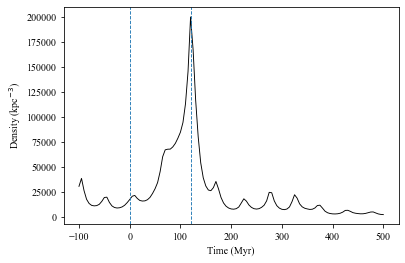

In [128]:
plt.plot(tlistnew, totaldensitylist, color = 'k', linewidth = 0.9)
plt.xlabel("Time (Myr)")
plt.ylabel("Density (kpc$^{-3}$)")

#y1 = 0
#y2 = 200000
#plt.vlines(0, ymin=y1, ymax=y2)
plt.axvline(x=0, linestyle = '--', linewidth = 0.9)
plt.axvline(x=120, linestyle = '--', linewidth = 0.9)

plt.savefig('densityplot.png', bbox_inches='tight', dpi = 150) #, pad_inches = 1)


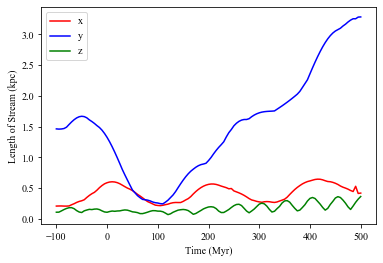

In [39]:
plt.plot(tlistnew, totalxrangelist, color = 'red', linewidth = 1.5, label ='x')
plt.plot(tlistnew, totalyrangelist, color = 'blue', linewidth = 1.5, label = 'y')
plt.plot(tlistnew, totalzrangelist, color = 'green', linewidth = 1.5, label='z')
plt.legend()
plt.xlabel('Time (Myr)')
plt.ylabel('Length of Stream (kpc)')
plt.savefig('length.png', bbox_inches='tight', dpi = 150)

In [69]:
DensityTimeCoords= np.array(list(zip(totaltimelist, totaldensitylist)))

In [70]:
type(DensityTimeCoords)
DensityTimeCoords

array([['-100.0 Myr', '30269.01353983779'],
       ['-95.0 Myr', '38285.57427982176'],
       ['-90.0 Myr', '25951.645481797'],
       ['-85.0 Myr', '17265.28730382536'],
       ['-80.0 Myr', '13059.845351581167'],
       ['-75.0 Myr', '11158.698477494343'],
       ['-70.0 Myr', '10676.696400921792'],
       ['-65.0 Myr', '10931.39936980249'],
       ['-60.0 Myr', '12218.002739461022'],
       ['-55.0 Myr', '15170.344258208315'],
       ['-50.0 Myr', '19076.158911283106'],
       ['-45.0 Myr', '19416.873856986713'],
       ['-40.0 Myr', '14145.96813027674'],
       ['-35.0 Myr', '10645.633707725941'],
       ['-30.0 Myr', '9032.613929288947'],
       ['-25.0 Myr', '8528.481449076162'],
       ['-20.0 Myr', '8761.840748644529'],
       ['-15.0 Myr', '9614.143226142034'],
       ['-10.0 Myr', '11268.3061457743'],
       ['-5.0 Myr', '13904.062009156116'],
       ['0.0 Myr', '17008.736430532528'],
       ['5.0 Myr', '20362.522977850327'],
       ['10.0 Myr', '21144.74514422269'],
       [

In [71]:
max(DensityTimeCoords[:,1])

'9703.51589852199'

In [22]:
256/totalvolumelist[0]

30269.01353983779

In [5]:
gifmaker('gifConvexHull/plot*', 'gifConvexHull/XYZ.gif')

In [ ]:
myList = [10,20,30,40,50,60,70,80,90]
myInt = 10
newList = [x / myInt for x in myList]

In [77]:
orbits= Orbit(vxvv=[gcR_list*u.pc,gcvR_list*u.km/u.s,gcvPHI_list*u.km/u.s,gcZ_list*u.pc,gcvZ_list*u.km/u.s,
                        gcPHI_list*u.rad])
time = 380.
ts= np.linspace(0,time,10000)*u.Myr
orbits.integrate(ts,MWPotential2014)


In [89]:
i=200*u.Myr

theta = np.median(orbits.phi(i))
x_p = orbits.x(i)*np.cos(theta) + orbits.y(i)*np.sin(theta)
y_p = -orbits.x(i)*np.sin(theta) + orbits.y(i)*np.cos(theta)
z_p = orbits.z(i)        
vx_p = orbits.vx(i)*np.cos(theta) + orbits.vy(i)*np.sin(theta)
vy_p = -orbits.vx(i)*np.sin(theta) + orbits.vy(i)*np.cos(theta)
vz_p = orbits.vz(i)


x_psubmed = x_p-np.median(x_p)
y_psubmed = y_p-np.median(y_p)
z_psubmed = z_p-np.median(z_p)


pts =np.array(list(zip(x_psubmed, y_psubmed, z_psubmed)))

In [90]:
pts

array([[-6.71659309e-02, -8.04421815e-02,  1.32604810e-02],
       [ 1.51765580e-02,  1.18434824e-01, -5.24271283e-03],
       [-5.53413098e-02,  7.54603470e-01, -2.39557416e-02],
       [-1.77712563e-02,  2.23151878e-01,  1.05117813e-02],
       [-1.42234173e-02,  3.55025848e-01, -4.62648979e-04],
       [-1.38539170e-03, -2.97330988e-01,  8.51456572e-02],
       [-7.41179836e-02,  6.66682408e-01, -3.00109872e-02],
       [-5.32185459e-02,  5.82364328e-01, -2.59968136e-02],
       [-2.92384927e-02,  4.76906809e-01, -2.85259581e-02],
       [-3.34744345e-02,  4.48404968e-01, -5.72121455e-03],
       [-1.02199593e-03,  1.57579882e-01, -1.47833269e-02],
       [-5.83511850e-03,  7.35657219e-02, -1.76134588e-02],
       [-7.61507204e-03,  8.69736398e-02, -5.86538537e-03],
       [-4.99785542e-02,  6.23678657e-01, -2.50383577e-02],
       [ 3.24013068e-03,  3.92413273e-01, -1.71376941e-02],
       [-6.59069070e-03, -4.58883123e-02,  7.49979459e-03],
       [-4.15828575e-03,  6.05710701e-01

In [91]:
hull = ConvexHull(pts)
hull.volume

0.017145791174039412

[143 181 131]
143
[ 0.0909452  -0.06278694  0.00790425  0.0909452 ]
[143 181  64]
143
[ 0.0909452  -0.06278694  0.00856791  0.0909452 ]
[ 50 143  64]
50
[0.06760544 0.0909452  0.00856791 0.06760544]
[213 131 191]
213
[-0.11791334  0.00790425 -0.13741394 -0.11791334]
[145  72 136]
145
[ 0.10215451 -0.02182841  0.14040457  0.10215451]
[161  50  64]
161
[-0.0034229   0.06760544  0.00856791 -0.0034229 ]
[161  50  72]
161
[-0.0034229   0.06760544 -0.02182841 -0.0034229 ]
[154  50 143]
154
[0.13687832 0.06760544 0.0909452  0.13687832]
[154 150 136]
154
[0.13687832 0.10864727 0.14040457 0.13687832]
[199 213 131]
199
[-0.06536674 -0.11791334  0.00790425 -0.06536674]
[139 150 136]
139
[0.12311648 0.10864727 0.14040457 0.12311648]
[118 150 131]
118
[0.06610906 0.10864727 0.00790425 0.06610906]
[118 199 131]
118
[ 0.06610906 -0.06536674  0.00790425  0.06610906]
[118 199  24]
118
[ 0.06610906 -0.06536674 -0.00171431  0.06610906]
[104 143 131]
104
[0.10208412 0.0909452  0.00790425 0.10208412]
[104 

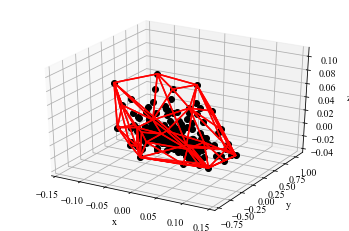

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull


# 8 points defining the cube corners
#pts = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
#                [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], ])

#hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
pts =np.array(list(zip(x_psubmed, y_psubmed, z_psubmed)))
hull = ConvexHull(pts)
for s in hull.simplices:
    print(s)
    print(s[0])
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    print(pts[s,0])
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

In [100]:
hull = ConvexHull(pts)

In [101]:
hull.volume

0.13437046936285443

In [102]:
pts

[(-0.0604497386136984, -0.2488506381812734, 0.04065023310229693),
 (0.018123410270419527, 0.13459569109399427, -0.059365475624221606),
 (-0.12381203656924278, 1.4526834608284847, -0.14745636517998176),
 (-0.009789701231129655, 0.35149446266787154, -0.126860760760885),
 (-0.018280091393121367, 0.6470464143762935, 0.04611131999912729),
 (-0.030582368256828474, -0.6874829066659156, 0.17420303428266956),
 (-0.12288735675411999, 1.289468512660477, 0.0415301026574082),
 (-0.08445152674294931, 1.1021302063603935, -0.10762422397173968),
 (-0.04534810475013984, 0.8782914298168802, -0.09713534047659964),
 (-0.045830947303148406, 0.8267726831196811, 0.031106709607667427),
 (0.001776413771143126, 0.23329045955165562, -0.13392283755249093),
 (-0.0009802338253184217, 0.0829347548423307, -0.07747420875559323),
 (-0.0013639652845522932, 0.08800584208397089, 0.051109825282149496),
 (-0.09052103268675893, 1.1920760143828613, -0.1368161206205638),
 (-0.0031473800632078053, 0.7075749373797895, -0.03448611

In [118]:
um = [(-0.0604497386136984, -0.2488506381812734, 0.04065023310229693),
 (0.018123410270419527, 0.13459569109399427, -0.059365475624221606),
 (-0.12381203656924278, 1.4526834608284847, -0.14745636517998176),
 (-0.009789701231129655, 0.35149446266787154, -0.126860760760885),
 (-0.018280091393121367, 0.6470464143762935, 0.04611131999912729),
 (-0.030582368256828474, -0.6874829066659156, 0.17420303428266956),
 (-0.12288735675411999, 1.289468512660477, 0.0415301026574082),
 (-0.08445152674294931, 1.1021302063603935, -0.10762422397173968),
 (-0.04534810475013984, 0.8782914298168802, -0.09713534047659964)]

#ax1=[1,2,3,5]
#ax2=[4,5,6,3]
#ax3 = [7,8,9,2]
#um = list(zip(ax1,ax2,ax3))

In [119]:
um

[(-0.0604497386136984, -0.2488506381812734, 0.04065023310229693),
 (0.018123410270419527, 0.13459569109399427, -0.059365475624221606),
 (-0.12381203656924278, 1.4526834608284847, -0.14745636517998176),
 (-0.009789701231129655, 0.35149446266787154, -0.126860760760885),
 (-0.018280091393121367, 0.6470464143762935, 0.04611131999912729),
 (-0.030582368256828474, -0.6874829066659156, 0.17420303428266956),
 (-0.12288735675411999, 1.289468512660477, 0.0415301026574082),
 (-0.08445152674294931, 1.1021302063603935, -0.10762422397173968),
 (-0.04534810475013984, 0.8782914298168802, -0.09713534047659964)]

In [120]:
hull1 = ConvexHull(um)

In [122]:
hull1.volume

0.014594464466283206

In [73]:
points

array([[0.83936018, 0.42957209],
       [0.47895861, 0.00213846],
       [0.65746246, 0.23194414],
       [0.90092214, 0.04527727],
       [0.82133916, 0.66229353],
       [0.52495116, 0.34504651],
       [0.35815587, 0.23190596],
       [0.00214643, 0.68878004],
       [0.01603786, 0.3216362 ],
       [0.66443388, 0.13076964],
       [0.30836252, 0.16134521],
       [0.15201145, 0.02180226],
       [0.03874688, 0.9038549 ],
       [0.78094227, 0.14288212],
       [0.55229831, 0.40742388],
       [0.30696422, 0.6126228 ],
       [0.19278257, 0.54945188],
       [0.52893804, 0.35674595],
       [0.7860462 , 0.5018134 ],
       [0.48580773, 0.15391652],
       [0.51705554, 0.17760306],
       [0.6712658 , 0.7660134 ],
       [0.77322543, 0.16694585],
       [0.82088604, 0.86869103],
       [0.45336157, 0.13663518],
       [0.89624855, 0.6129969 ],
       [0.22323318, 0.95551617],
       [0.23689442, 0.25506851],
       [0.22965344, 0.77629144],
       [0.22709017, 0.9975512 ]])

In [74]:
points[:,0]

array([0.83936018, 0.47895861, 0.65746246, 0.90092214, 0.82133916,
       0.52495116, 0.35815587, 0.00214643, 0.01603786, 0.66443388,
       0.30836252, 0.15201145, 0.03874688, 0.78094227, 0.55229831,
       0.30696422, 0.19278257, 0.52893804, 0.7860462 , 0.48580773,
       0.51705554, 0.6712658 , 0.77322543, 0.82088604, 0.45336157,
       0.89624855, 0.22323318, 0.23689442, 0.22965344, 0.22709017])

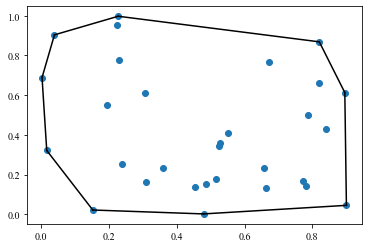

In [75]:
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')
    
#plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
#plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

In [82]:
hull.simplices

array([[12,  7],
       [12, 29],
       [23, 29],
       [ 8,  7],
       [ 8, 11],
       [ 1,  3],
       [ 1, 11],
       [25,  3],
       [25, 23]], dtype=int32)

In [86]:
pts

[(-0.0604497386136984, -0.2488506381812734, 0.04065023310229693),
 (0.018123410270419527, 0.13459569109399427, -0.059365475624221606),
 (-0.12381203656924278, 1.4526834608284847, -0.14745636517998176),
 (-0.009789701231129655, 0.35149446266787154, -0.126860760760885),
 (-0.018280091393121367, 0.6470464143762935, 0.04611131999912729),
 (-0.030582368256828474, -0.6874829066659156, 0.17420303428266956),
 (-0.12288735675411999, 1.289468512660477, 0.0415301026574082),
 (-0.08445152674294931, 1.1021302063603935, -0.10762422397173968),
 (-0.04534810475013984, 0.8782914298168802, -0.09713534047659964),
 (-0.045830947303148406, 0.8267726831196811, 0.031106709607667427),
 (0.001776413771143126, 0.23329045955165562, -0.13392283755249093),
 (-0.0009802338253184217, 0.0829347548423307, -0.07747420875559323),
 (-0.0013639652845522932, 0.08800584208397089, 0.051109825282149496),
 (-0.09052103268675893, 1.1920760143828613, -0.1368161206205638),
 (-0.0031473800632078053, 0.7075749373797895, -0.03448611

In [53]:
x1 = 0, 0, 0, 1, 1,
y1 = 0, 0, 1, 1, 0,
z1 = 0, 1, 1, 0, 0

#pts1 = list(zip(x1, y1, z1))
pts1 = [(0,0,0), (0,0,3), (3,0,0), (0,3,3), (3,0,3), (0,3,0), (3,3,0), (3,3,3)]
hull1 = ConvexHull(pts1)
volume1 = hull1.volume
density1 = 5/volume1 #number of stars / volume
pts1 = np.array(pts1)

In [54]:
density1

0.18518518518518517

In [55]:
volume1

27.0

In [57]:
hull1.simplices

array([[5, 1, 3],
       [5, 1, 0],
       [4, 1, 0],
       [4, 2, 0],
       [6, 5, 0],
       [6, 2, 0],
       [7, 1, 3],
       [7, 4, 1],
       [7, 5, 3],
       [7, 6, 5],
       [7, 4, 2],
       [7, 6, 2]], dtype=int32)

In [85]:
pts1

array([[0, 0, 0],
       [0, 0, 3],
       [3, 0, 0],
       [0, 3, 3],
       [3, 0, 3],
       [0, 3, 0],
       [3, 3, 0],
       [3, 3, 3]])

[5 1 3]
5
[-0.03058237  0.01812341 -0.0097897  -0.03058237]
[5 1 0]
5
[-0.03058237  0.01812341 -0.06044974 -0.03058237]
[4 1 0]
4
[-0.01828009  0.01812341 -0.06044974 -0.01828009]
[4 2 0]
4
[-0.01828009 -0.12381204 -0.06044974 -0.01828009]
[6 5 0]
6
[-0.12288736 -0.03058237 -0.06044974 -0.12288736]
[6 2 0]
6
[-0.12288736 -0.12381204 -0.06044974 -0.12288736]
[7 1 3]
7
[-0.08445153  0.01812341 -0.0097897  -0.08445153]
[7 4 1]
7
[-0.08445153 -0.01828009  0.01812341 -0.08445153]
[7 5 3]
7
[-0.08445153 -0.03058237 -0.0097897  -0.08445153]
[7 6 5]
7
[-0.08445153 -0.12288736 -0.03058237 -0.08445153]
[7 4 2]
7
[-0.08445153 -0.01828009 -0.12381204 -0.08445153]
[7 6 2]
7
[-0.08445153 -0.12288736 -0.12381204 -0.08445153]


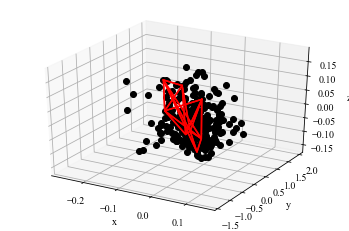

In [71]:
pts1[s,2]

array([3, 0, 0, 3])

In [70]:
pts1[s]

array([[3, 3, 3],
       [3, 3, 0],
       [3, 0, 0],
       [3, 3, 3]])

[3 2 1]
[3 2 1 3]
[3 1 0]
[3 1 0 3]
[5 1 0]
[5 1 0 5]
[5 4 0]
[5 4 0 5]
[7 3 0]
[7 3 0 7]
[7 4 0]
[7 4 0 7]
[6 2 1]
[6 2 1 6]
[6 5 1]
[6 5 1 6]
[6 3 2]
[6 3 2 6]
[6 7 3]
[6 7 3 6]
[6 5 4]
[6 5 4 6]
[6 7 4]
[6 7 4 6]


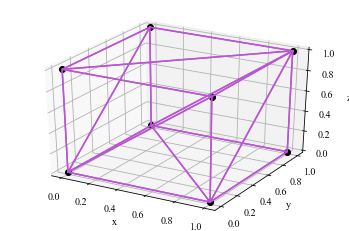

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull


# 8 points defining the cube corners
pts = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], ])

hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    print(s)
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    print(s)
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], ls = "-", color = "mediumorchid")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

In [59]:
pts.T[0]

array([0, 1, 1, 0, 0, 1, 1, 0])

In [43]:
pts

array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [0, 1, 1]])

In [45]:
np.array(pts1)

array([[0, 0, 0],
       [0, 0, 3],
       [3, 0, 0],
       [0, 3, 3],
       [3, 0, 3],
       [0, 3, 0],
       [3, 3, 0],
       [3, 3, 3]])